In [ ]:
print('hi') # 실행 : ctrl_+ enter 

hi


In [ ]:
# 아래 셀 추가 : ctrl + m + b
# 위 셀 추가 : ctrl + m + a
# 마크다운 : ctrl + m + m
# 마크다운 해제 : ctrl + m + y
# 실행 단축키는 주피터와 동일

### 목표
 - 폐암환자의 생존을 예측하는 모델을 만들어보자!
 - 신경망을 활용하여 2진분류 문제를 해결해보자!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###데이터 불러오기

In [ ]:
!pwd # cd

/content


In [ ]:
# colab에서 데이터 불러오는 방법 확인
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ThoraricSurgery.csv',header=None) # 컬럼명 인덱스값으로 설정하는 방법(header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,293,1,3.80,2.80,0,0,0,0,0,0,12,0,0,0,1,0,62,0
1,1,2,2.88,2.16,1,0,0,0,1,1,14,0,0,0,1,0,60,0
2,8,2,3.19,2.50,1,0,0,0,1,0,11,0,0,1,1,0,66,1
3,14,2,3.98,3.06,2,0,0,0,1,1,14,0,0,0,1,0,80,1
4,17,2,2.21,1.88,0,0,1,0,0,0,12,0,0,0,1,0,56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,98,6,3.04,2.40,2,0,0,0,1,0,11,0,0,0,1,0,76,0
466,369,6,3.88,2.72,1,0,0,0,1,0,12,0,0,0,1,0,77,0
467,406,6,5.36,3.96,1,0,0,0,1,0,12,0,0,0,0,0,62,0
468,25,8,4.32,3.20,0,0,0,0,0,0,11,0,0,0,0,0,58,1


In [ ]:
# 문제는 마지막 열을 제외한 모든 컬럼
# 답은 마지막 열 - 폐암인지 아닌지

### 데이터 분할

In [ ]:
# 문제와 답
X = data.iloc[:,:-1] # 뒤에서 부터 세기위해선 -1 입력 (마지막 열)
y = data.iloc[:,-1]

print(X.shape)
print(y.shape)

# 트레인용 테스트용
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=5)
print('훈련용 문제 :',X_train.shape)
print('훈련용 답 : ', y_train.shape)
print('테스트용 문제 : ',X_test.shape)
print('테스트용 답 : ',y_test.shape)

(470, 17)
(470,)
훈련용 문제 : (329, 17)
훈련용 답 :  (329,)
테스트용 문제 :  (141, 17)
테스트용 답 :  (141,)


#### keras를 활용하여 딥러닝 신경맘을 구성해보자
 - 1. 신경망 구조 설계(뼈대, 층)
 - 2. 학습/ 평가 방법 설정
 - 3. 학습 + 시각화
 - 4. 평가
 

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation

In [ ]:
# 1. 신경망 구조 설계
model = Sequential()

# 입력층(input_dim) + 중간층(Dense(units))
# input_dim : 특성(입력) 개수 만큼
# activation : 활성화 함수는 Dense 함수 안의 매개변수 값으로 지정
model.add(Dense(units = 34, input_dim = 17, activation='sigmoid'))

# 중간층
model.add(Dense(units = 20, activation = 'sigmoid')) # 층을 쌓음 add(Dense(units=?))
model.add(Dense(units = 10, activation = 'sigmoid'))

# 출력층 -> y_train의 크기 개수만큼 해야댐
# 이진분류 !!! 유닛 = 1, 활성화 = 시그모이드
# 이진분류는 1개만 적어도 된다
model.add(Dense(1, activation='sigmoid'))

# 모델 정보
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 34)                612       
                                                                 
 dense_1 (Dense)             (None, 20)                700       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,533
Trainable params: 1,533
Non-trainable params: 0
_________________________________________________________________


#### activation(활성화함수) - 자극에 대한 반응여부를 결정하는 함수
 - 1. 회귀 출력층 : linear(항등함수) -> 신경망에서 도출된 수치값을 그대로 예측값으로 사용
 - 2. 분류 : 선형모델이 출력하는 수치값으로는 분류문제를 해결하기 어려움, 분류모델일 경우 확률 정보를 바탕으로 판단하는 것이 더욱 정확
    - 이진분류 : sigmoid -> 0 또는 1로 분류 (0.5를 기준으로 높고 낮은지에 대한 확률 정보를 바탕으로 최종 예측값 출력)

In [ ]:
# 2. 학습/평가 방법 설정
# binary_crossentropy : 이진분류에 사용되는 손실함수(비용함수)
# 오차의 평균을 구하는 mse이와 같지만 , 0~1 사이 값으로 변환후 평균 오차를 구함
# 손실함수(=비용함수)(loss) = mse
model.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd', # 최적화 함수 : 확률적 경사하강법
              metrics = ['accuracy']) #평가방법 설정 : 정확도


In [ ]:
# 3. 학습
h = model.fit(X_train, y_train, epochs = 150) # epochs 모델 학습 횟수

Epoch 1/150
11/11 [==============================] - 1s 2ms/step - loss: 0.7666 - accuracy: 0.1459
Epoch 2/150
11/11 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5988
Epoch 3/150
11/11 [==============================] - 0s 1ms/step - loss: 0.6246 - accuracy: 0.8541
Epoch 4/150
11/11 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.8541
Epoch 5/150
11/11 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.8541
Epoch 6/150
11/11 [==============================] - 0s 1ms/step - loss: 0.5200 - accuracy: 0.8541
Epoch 7/150
11/11 [==============================] - 0s 2ms/step - loss: 0.5009 - accuracy: 0.8541
Epoch 8/150
11/11 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.8541
Epoch 9/150
11/11 [==============================] - 0s 1ms/step - loss: 0.4711 - accuracy: 0.8541
Epoch 10/150
11/11 [==============================] - 0s 1ms/step - loss: 0.4608 - accuracy: 0.8541
Epoch 11/

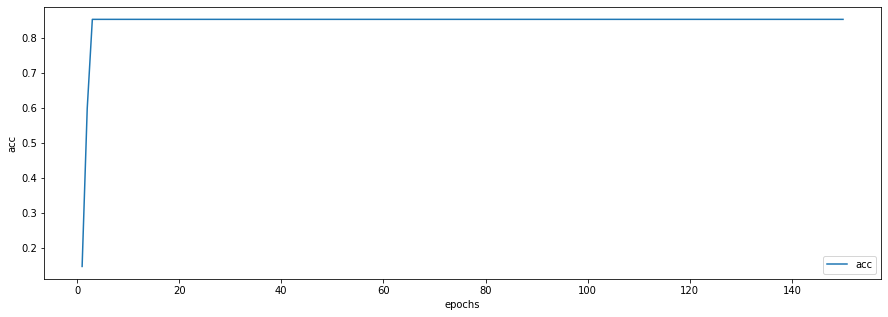

In [ ]:
# 시각화 - 학습횟수에 따른 정확도 변화 그래프
plt.figure(figsize = (15,5))
plt.plot(range(1,151),
         h.history['accuracy'],
         label ='acc')
plt.legend()
plt.xlabel('epochs') # epochs = 학습횟수
plt.ylabel('acc')
plt.show()

In [ ]:
# 4. 모델 평가
model.evaluate(X_test, y_test)[1]

5/5 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.8440


0.8439716100692749

In [ ]:
# 예측
model.predict(X_test)

array([[0.14753458],
       [0.1458584 ],
       [0.1453813 ],
       [0.14424509],
       [0.14467552],
       [0.14411971],
       [0.14444101],
       [0.14823297],
       [0.14414418],
       [0.14854658],
       [0.15348402],
       [0.14409804],
       [0.14429417],
       [0.14810988],
       [0.15192735],
       [0.14410245],
       [0.14754516],
       [0.15341377],
       [0.14770016],
       [0.14807108],
       [0.14437044],
       [0.14410454],
       [0.14410287],
       [0.1443209 ],
       [0.14496958],
       [0.14412144],
       [0.14411119],
       [0.14714476],
       [0.14411458],
       [0.14747107],
       [0.14438409],
       [0.14411417],
       [0.15833735],
       [0.15215734],
       [0.14415786],
       [0.14755923],
       [0.1441186 ],
       [0.14854059],
       [0.14413694],
       [0.1442624 ],
       [0.14413017],
       [0.1482962 ],
       [0.14409968],
       [0.14796418],
       [0.14410892],
       [0.14837548],
       [0.14616787],
       [0.144